# Data Management Project: Bitcoin sentiment analysis

### Data sources:
- Bitcoin Volume: API endpoint -> https://api.binance.com/api/v3/klines
- NyTimes news: API endpoint -> https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey

(Limit NYtimes: Yes, there are two rate limits per API: 500 requests per day and 5 requests per minute. You should sleep 12 seconds between calls to avoid hitting the per minute rate limit. If you need a higher rate limit, please contact us at code@nytimes.com.)

Important: 
- create in your environment a .env file
- write: NY_KEY = "your_key"
- use the command load_dotenv()
- key = os.getenv("NY_KEY")

In [26]:
!pip install python-dotenv


[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
!pip install kafka-python pymongo

     -------------------------------------- 859.2/859.2 kB 4.5 MB/s eta 0:00:00
     -------------------------------------- 331.1/331.1 kB 6.8 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests
import json
from datetime import datetime
import os
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import time

from kafka import KafkaProducer
from kafka import KafkaConsumer

from pymongo import MongoClient

load_dotenv()

True

### BitCoin:

In [9]:
url = "https://api.binance.com/api/v3/klines"
params = {
    "symbol": "BTCUSDT",
    "interval": "1d",
    "limit": 10000
}

response = requests.get(url, params=params)
data = response.json()

# Converte le candele in un formato leggibile
candles = []
for c in data:
    open_time = datetime.fromtimestamp(c[0]/1000)   # converte ms → datetime
    open_price = float(c[1])
    high = float(c[2])
    low = float(c[3])
    close_price = float(c[4])

    candles.append({
        "date": open_time.strftime("%Y-%m-%d"),
        "open": open_price,
        "high": high,
        "low": low,
        "close": close_price
    })

for c in candles:
    print(c)


{'date': '2023-03-15', 'open': 24670.41, 'high': 25196.97, 'low': 23896.95, 'close': 24285.66}
{'date': '2023-03-16', 'open': 24285.66, 'high': 25167.4, 'low': 24123.0, 'close': 24998.78}
{'date': '2023-03-17', 'open': 24998.78, 'high': 27756.84, 'low': 24890.0, 'close': 27395.13}
{'date': '2023-03-18', 'open': 27395.13, 'high': 27724.85, 'low': 26578.0, 'close': 26907.49}
{'date': '2023-03-19', 'open': 26907.49, 'high': 28390.1, 'low': 26827.22, 'close': 27972.87}
{'date': '2023-03-20', 'open': 27972.87, 'high': 28472.0, 'low': 27124.47, 'close': 27717.01}
{'date': '2023-03-21', 'open': 27717.01, 'high': 28438.55, 'low': 27303.1, 'close': 28105.47}
{'date': '2023-03-22', 'open': 28107.81, 'high': 28868.05, 'low': 26601.8, 'close': 27250.97}
{'date': '2023-03-23', 'open': 27250.97, 'high': 28750.0, 'low': 27105.0, 'close': 28295.41}
{'date': '2023-03-24', 'open': 28295.42, 'high': 28374.3, 'low': 27000.0, 'close': 27454.47}
{'date': '2023-03-25', 'open': 27454.46, 'high': 27787.33, 'lo

In [2]:
import yfinance as yf

# yfinance aggira i blocchi perché simula un browser che visita il sito
# Non ha limiti "hard" sugli anni passati
btc = yf.download("BTC-USD", start="2021-01-01", end="2025-12-08")

C:\Users\tomma\AppData\Local\Temp\ipykernel_30208\1402111293.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2021-01-01", end="2025-12-08")
[*********************100%***********************]  1 of 1 completed


In [3]:
df = pd.DataFrame(btc) # Convert into DataFrame
print(df.columns)
df.head()

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2021-01-01,29374.152344,29600.626953,28803.585938,28994.009766,40730301359
2021-01-02,32127.267578,33155.117188,29091.181641,29376.455078,67865420765
2021-01-03,32782.023438,34608.558594,32052.316406,32129.408203,78665235202
2021-01-04,31971.914062,33440.218750,28722.755859,32810.949219,81163475344
2021-01-05,33992.429688,34437.589844,30221.187500,31977.041016,67547324782


In [5]:
df.isna().sum() # There is no Missing Values

Price   Ticker 
Close   BTC-USD    0
High    BTC-USD    0
Low     BTC-USD    0
Open    BTC-USD    0
Volume  BTC-USD    0
dtype: int64

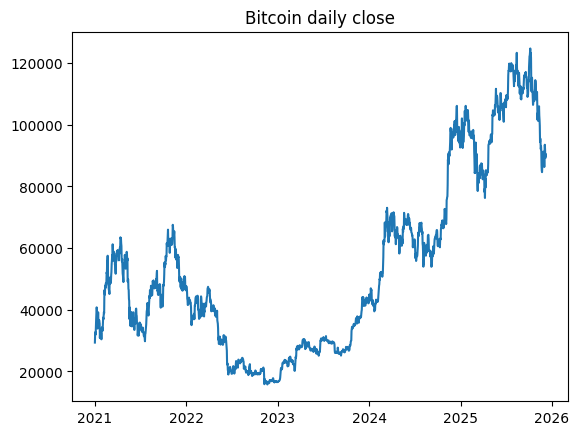

In [6]:
plt.figure()
plt.plot(df.index,df['Close']['BTC-USD'])
plt.title("Bitcoin daily close")
plt.show()

### NyTimes article:

In [10]:

key = os.getenv("NY_KEY") # your api key
query = 'Bitcoin'
i = 0
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

In [17]:
nyresponse = requests.get(url).json()
nyresponse

{'status': 'OK',
 'copyright': 'Copyright (c) 2025 The New York Times Company. All Rights Reserved.',
 'response': {'docs': [{'abstract': 'Bitcoin has plunged more than 30 percent and Ether is down around 40 percent in recent months, as gains from President Trump’s pro-crypto policies evaporated.',
    'byline': {'original': 'By David Yaffe-Bellany and Kailyn Rhone'},
    'document_type': 'article',
    'headline': {'main': 'Those Sky-High Bitcoin Prices Everyone Said Were Here to Stay? They Left.',
     'kicker': '',
     'print_headline': 'Those Sky-High Prices Forecast for Bitcoin? They Didn’t Pan Out.'},
    '_id': 'nyt://article/8e021b81-4ea1-5475-b807-1ae1c42219b5',
    'keywords': [{'name': 'Subject', 'value': 'Virtual Currency', 'rank': 1},
     {'name': 'Subject',
      'value': 'United States Politics and Government',
      'rank': 2},
     {'name': 'Subject', 'value': 'Bitcoin (Currency)', 'rank': 3},
     {'name': 'Subject',
      'value': 'Regulation and Deregulation of In

In [18]:
len(nyresponse["response"]["docs"])

10

In [19]:
i = 1
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

In [19]:
nyresponse = requests.get(url).json()

nyresponse

with open("nytimes.json", "w", encoding="utf-8") as f:
    json.dump(nyresponse, f, ensure_ascii=False, indent=4)

In [11]:
key = os.getenv("NY_KEY")
query = 'crypto'
i = 0
url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}'

nyresponse = requests.get(url).json()

nyresponse

{'fault': {'faultstring': 'Invalid ApiKey',
  'detail': {'errorcode': 'oauth.v2.InvalidApiKey'}}}

In [ ]:
# Definition of the Kafka Producer:

producer = KafkaProducer(
    bootstrap_servers="localhost:9092",
    value_serializer=lambda v: json.dumps(v).encode("utf-8")
)



1. **Data retrieval from the New York Times API**  
   - Uses the API key stored in the environment variable `NY_KEY`.  
   - Searches for the queries `"Bitcoin"` and `"Crypto"`.  
   - Iterates through 100 pages of results for each query.

2. **Request and error handling**  
   - Each HTTP request is executed using `requests.get`.  
   - The response status is checked with `raise_for_status()` to catch any HTTP errors.  
   - In case of an error (e.g., `429 Too Many Requests`, timeout, connection issues), the error is logged and the loop continues with the next request.

3. **Sending data to Kafka**  
   - If the response is valid, the JSON data is sent to a Kafka topic corresponding to the query (`Bitcoin` or `Crypto`).  
   - This allows real-time processing or storage of the data via a Kafka consumer.

4. **Rate limit management**  
   - After each request, the script waits 15 seconds (`time.sleep(15)`) to avoid exceeding NYT API limits, reducing the risk of `429 Too Many Requests` errors.

**Note:** The script is designed to safely scrape data while respecting the NYT API's per-minute and daily limits, sending the collected data to Kafka for further processing.


In [54]:
key = os.getenv("NY_KEY") # your key
query = ["Bitcoin", "Crypto"] # search for Bitcoin and Crypto in general
for i in range(100): # Set 100 pages
    for q in query: # one call for each query
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={query}&page={i}&api-key={key}' # update url 

        try:
            response = requests.get(url)
            response.raise_for_status()  # raise error for non-200 responses
            
            data = response.json()

            TOPIC = q

            # send only if the response is valid
            producer.send(TOPIC, data)
            print(f"Send result for '{q}', page {i}")

        except Exception as e: 
            print(f"Error in ='{q}', page={i}: {e}")
            continue  # skip

        time.sleep(15)



        

Send result for 'Bitcoin', page 0
Send result for 'Crypto', page 0
Send result for 'Bitcoin', page 1
Send result for 'Crypto', page 1
Send result for 'Bitcoin', page 2
Send result for 'Crypto', page 2
Send result for 'Bitcoin', page 3
Send result for 'Crypto', page 3
Send result for 'Bitcoin', page 4
Send result for 'Crypto', page 4
Send result for 'Bitcoin', page 5
Send result for 'Crypto', page 5
Send result for 'Bitcoin', page 6
Send result for 'Crypto', page 6
Send result for 'Bitcoin', page 7
Send result for 'Crypto', page 7
Send result for 'Bitcoin', page 8
Send result for 'Crypto', page 8
Send result for 'Bitcoin', page 9
Send result for 'Crypto', page 9
Send result for 'Bitcoin', page 10
Send result for 'Crypto', page 10
Send result for 'Bitcoin', page 11
Send result for 'Crypto', page 11
Send result for 'Bitcoin', page 12
Send result for 'Crypto', page 12
Send result for 'Bitcoin', page 13
Send result for 'Crypto', page 13
Send result for 'Bitcoin', page 14
Send result for 'Cr

In [12]:
# Prova 2:

# Configura il producer (assicurati di avere il serializer JSON)
producer = KafkaProducer(
    bootstrap_servers=['localhost:9092'],
    value_serializer=lambda x: json.dumps(x).encode('utf-8')
)

key = os.getenv("NY_KEY")
queries = ["Bitcoin", "Crypto"] # Ho rinominato in plurale per chiarezza

print("Inizio scaricamento...")

for i in range(100): # Per 100 pagine
    for q in queries: # Per ogni parola chiave
        time.sleep(15)
        
        # CORREZIONE 1: Usiamo {q} (la singola parola) e non {query} (la lista intera)
        url = f'https://api.nytimes.com/svc/search/v2/articlesearch.json?q={q}&page={i}&api-key={key}'
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            
            data = response.json()
            
            # Estraiamo la lista degli articoli dalla risposta grezza
            articles = data.get('response', {}).get('docs', [])
            
            if not articles:
                print(f"Nessun articolo trovato per '{q}' a pagina {i}")
                continue

            # CORREZIONE 2: Inviamo UN messaggio per OGNI articolo (non tutta la pagina)
            for article in articles:
                
                # Creiamo un dizionario pulito (solo ciò che ti serve)
                clean_doc = {
                    'remote_id': article.get('_id'), # ID univoco del NYT
                    'web_url': article.get('web_url'),
                    'pub_date': article.get('pub_date'),
                    'abstract': article.get('abstract'),
                    'lead_paragraph': article.get('lead_paragraph'),
                    'title': article.get('headline', {}).get('main'),
                    'source_query': q # Importante: ci salviamo da quale ricerca arriva!
                }
                
                # Inviamo al topic corrispondente
                # (Puoi usare un topic unico 'articles-topic' o mantenerli separati come fai tu)
                TOPIC = q 
                producer.send(TOPIC, clean_doc)
            
            # Flush per assicurarsi che i messaggi partano subito
            producer.flush() 
            print(f"Inviati {len(articles)} articoli puliti per '{q}', pagina {i}")

        except Exception as e: 
            print(f"Errore in '{q}', pagina={i}: {e}")
            continue

        # Rispetta i limiti dell'API (il NYT è severo, 15 sec va bene)
        

Inizio scaricamento...
Inviati 10 articoli puliti per 'Bitcoin', pagina 0
Inviati 10 articoli puliti per 'Crypto', pagina 0
Inviati 10 articoli puliti per 'Bitcoin', pagina 1
Inviati 10 articoli puliti per 'Crypto', pagina 1
Inviati 10 articoli puliti per 'Bitcoin', pagina 2
Inviati 10 articoli puliti per 'Crypto', pagina 2
Inviati 10 articoli puliti per 'Bitcoin', pagina 3
Inviati 10 articoli puliti per 'Crypto', pagina 3
Inviati 10 articoli puliti per 'Bitcoin', pagina 4
Inviati 10 articoli puliti per 'Crypto', pagina 4
Inviati 10 articoli puliti per 'Bitcoin', pagina 5
Inviati 10 articoli puliti per 'Crypto', pagina 5
Inviati 10 articoli puliti per 'Bitcoin', pagina 6
Inviati 10 articoli puliti per 'Crypto', pagina 6
Inviati 10 articoli puliti per 'Bitcoin', pagina 7
Inviati 10 articoli puliti per 'Crypto', pagina 7
Inviati 10 articoli puliti per 'Bitcoin', pagina 8
Inviati 10 articoli puliti per 'Crypto', pagina 8
Inviati 10 articoli puliti per 'Bitcoin', pagina 9
Inviati 10 artico

1. **Kafka Consumers Setup**  
   - Two separate consumers are created:
     - `consumer_bitcoin` subscribes to the `"Bitcoin"` topic.
     - `consumer_crypto` subscribes to the `"Crypto"` topic.
   - Both consumers:
     - Connect to the Kafka broker at `localhost:9092`.
     - Deserialize messages from JSON using `json.loads`.
     - Start reading from the earliest available message (`auto_offset_reset="earliest"`) to process past messages.
     - Use a new consumer group `"debug-group"` to avoid committing offsets from previous runs.

2. **MongoDB Setup**  
   - Connects to a local MongoDB instance (`mongodb://localhost:27017`).
   - Uses the database `bitcoin_pr`.
   - Stores articles in the collection `Article`.

3. **Message Consumption and Storage**  
   - For each message received from the `"Bitcoin"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Bitcoin"`.
     - Inserts the document into the MongoDB collection.
   - For each message received from the `"Crypto"` topic:
     - Prints the message.
     - Adds a `query` field with value `"Crypto"`.
     - Inserts the document into MongoDB.

4. **Notes**
   - Using `auto_offset_reset="earliest"` allows the consumer to read **all previous messages** in the topic, which is useful for debugging or reprocessing data.
   - Each consumer runs in a blocking loop, continuously waiting for new messages.
   - Ensure MongoDB is running locally before executing the script.



In [13]:
consumer_bitcoin = KafkaConsumer(
    "Bitcoin",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group",          # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)

consumer_crypto = KafkaConsumer(
    "Crypto",
    bootstrap_servers="localhost:9092",
    value_deserializer=lambda v: json.loads(v.decode("utf-8")),
    auto_offset_reset="earliest",   # <--- importante per vedere i messaggi vecchi
    enable_auto_commit=True,
    group_id="debug-group-crypto",         # nuovo group per rileggere da inizio
    consumer_timeout_ms=10000
)



In [14]:
client = MongoClient("mongodb://localhost:27017")

db = client['bitcoin_project']

collection = db['Article']

print("Waiting for Bitcoin messages...")
for msg in consumer_bitcoin:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Bitcoin'
    collection.insert_one(doc)

print("Waiting for Crypto messages...")
for msg in consumer_crypto:
    print("Received:", msg.value)
    doc = msg.value
    doc['query'] = 'Crypto'
    collection.insert_one(doc)

print("All messages consumed.")


Waiting for Bitcoin messages...
Received: {'remote_id': 'nyt://article/8e021b81-4ea1-5475-b807-1ae1c42219b5', 'web_url': 'https://www.nytimes.com/2025/12/03/technology/cryptocurrencies-tumble-trump-rally.html', 'pub_date': '2025-12-03T10:02:24Z', 'abstract': 'Bitcoin has plunged more than 30 percent and Ether is down around 40 percent in recent months, as gains from President Trump’s pro-crypto policies evaporated.', 'lead_paragraph': None, 'title': 'Those Sky-High Bitcoin Prices Everyone Said Were Here to Stay? They Left.', 'source_query': 'Bitcoin'}
Received: {'remote_id': 'nyt://article/927fd981-6216-50dd-9f3d-b89fdff7c84c', 'web_url': 'https://www.nytimes.com/2025/10/09/technology/roger-ver-bitcoin-justice-department-deal.html', 'pub_date': '2025-10-09T20:09:51Z', 'abstract': 'In the Trump administration’s latest example of dialing back cryptocurrency enforcement, Roger Ver agreed to pay about $48 million to end a tax fraud case.', 'lead_paragraph': None, 'title': 'Crypto Investor 

In [8]:
client = MongoClient("mongodb://localhost:27017")

db = client['bitcoin_project']

collection = db['Article']


In [9]:
pipeline = [
    {
        "$group": {
            "_id": "$web_url",  # Sostituisci con il campo che identifica l'univocità (es. id, url, title)
            "count": {"$sum": 1},
            "docs": {"$push": "$_id"} # Opzionale: salva gli ID di Mongo dei duplicati
        }
    },
    {
        "$match": {
            "count": {"$gt": 1} # Filtra solo quelli che compaiono più di una volta
        }
    }
]

duplicati = list(collection.aggregate(pipeline))

print(f"Trovati {len(duplicati)} articoli duplicati.")

for d in duplicati[:5]: # Stampa i primi 5 esempi
    print(f"L'URL {d['_id']} appare {d['count']} volte.")

Trovati 430 articoli duplicati.
L'URL https://www.nytimes.com/2024/11/11/briefing/trump-administration-climate-amsterdam.html appare 2 volte.
L'URL https://www.nytimes.com/2023/10/20/technology/crypto-influencers-degenerates-sam-bankman-fried-trial.html appare 2 volte.
L'URL https://www.nytimes.com/explain/2022/cryptocurrency-guide/what-are-cryptocurrencies appare 2 volte.
L'URL https://www.nytimes.com/2023/01/17/business/ftx-assets.html appare 2 volte.
L'URL https://www.nytimes.com/2023/02/10/business/dealbook/sec-kraken-staking.html appare 2 volte.


In [10]:
num_articles = collection.count_documents({})
print(f"Number of articles in the collection: {num_articles}")
# Conta articoli per query specifica
num_bitcoin = collection.count_documents({'query': 'Bitcoin'})
num_crypto = collection.count_documents({'query': 'Crypto'})

print(f"Number of Bitcoin articles: {num_bitcoin}")
print(f"Number of Crypto articles: {num_crypto}")



Number of articles in the collection: 2000
Number of Bitcoin articles: 1000
Number of Crypto articles: 1000


In [17]:
# 1. Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_pr2']
collection = db['Article']

pipeline = [
    # 1. "Srotola" l'array dei documenti. 
    # Questo trasforma un documento contenente 10 articoli in 10 documenti temporanei separati.
    {
        "$unwind": "$response.docs"
    },
    
    # 2. Filtra quelli che hanno un abstract valido
    {
        "$match": {
            "response.docs.abstract": {"$exists": True, "$ne": ""}
        }
    },
    
    # 3. Raggruppa usando il percorso corretto (dentro response -> docs)
    {
        "$group": {
            "_id": "$response.docs.abstract",  # <--- IL PERCORSO CHE CERCAVI
            "count": {"$sum": 1},
            "queries": {"$addToSet": "$query"} # Per vedere se viene da Bitcoin o Crypto
        }
    },
    
    # 4. Tieni solo i duplicati
    {
        "$match": {
            "count": {"$gt": 1}
        }
    },
    
    # 5. Ordina
    {
        "$sort": {"count": -1}
    }
]

# Esecuzione
duplicati = list(collection.aggregate(pipeline))

print(f"Trovati {len(duplicati)} abstract duplicati.\n")

for d in duplicati:
    print(f"Abstract: {d['_id'][:50]}...")
    print(f"Presente {d['count']} volte in: {d['queries']}")
    print("-" * 30)

Trovati 937 abstract duplicati.

Abstract: How luxury cars, $500,000 bar tabs and a mysteriou...
Presente 10 volte in: ['Crypto', 'Bitcoin']
------------------------------
Abstract: Plus, was Shakespeare a bad husband?...
Presente 10 volte in: ['Crypto', 'Bitcoin']
------------------------------
Abstract: Crypto is a lot of things – including terribly exp...
Presente 9 volte in: ['Crypto', 'Bitcoin']
------------------------------
Abstract: Ross Ulbricht, who created the Silk Road dark web ...
Presente 8 volte in: ['Crypto', 'Bitcoin']
------------------------------
Abstract: In “The Mysterious Mr. Nakamoto,” Benjamin Wallace...
Presente 8 volte in: ['Bitcoin', 'Crypto']
------------------------------
Abstract: The prospect of using taxpayer money to stockpile ...
Presente 8 volte in: ['Bitcoin', 'Crypto']
------------------------------
Abstract: It is a sharp pivot away from the cautious approac...
Presente 8 volte in: ['Crypto', 'Bitcoin']
------------------------------
Abstract: Met

In [18]:
pipeline_date_unica = [
    {
        "$unwind": "$response.docs"
    },
    {
        # Raggruppa usando l'ID univoco dell'articolo (campo _id all'interno di response.docs)
        "$group": {
            "_id": "$response.docs._id", 
            "Titolo_Articolo": { "$first": "$response.docs.headline.main" }, 
            "Data_Pubblicazione": { "$first": "$response.docs.pub_date" },
            "Query_Origine": { "$first": "$query" }
        }
    },
    {
        "$sort": {
            "Data_Pubblicazione": 1
        }
    },
    {
        "$project": {
            "_id": 0,
            "Titolo_Articolo": 1,
            "Data_Pubblicazione": 1,
            "Query_Origine": 1
        }
    }
]

# Esecuzione della pipeline
risultati_cursor = collection.aggregate(pipeline_date_unica)

# Stampa dei risultati
print("### Articoli Unici Estratti ###")
print("-" * 40)

conteggio = 0
for articolo in risultati_cursor:
    print(f"[{articolo['Query_Origine']}] {articolo['Data_Pubblicazione']} - {articolo['Titolo_Articolo']}")
    conteggio += 1

print("-" * 40)
print(f"Totale articoli unici estratti: {conteggio}")

### Articoli Unici Estratti ###
----------------------------------------
[Bitcoin] 2013-05-06T23:24:31Z - A Push for a Bitcoin Buttonwood
[Bitcoin] 2013-05-07T11:53:29Z - Pondering a Berkshire Without Buffett
[Bitcoin] 2013-05-29T04:07:02Z - Unlike Liberty Reserve, Bitcoin Is Not Anonymous — Yet
[Bitcoin] 2013-07-02T00:53:47Z - Winklevoss Twins Plan First Fund for Bitcoins
[Bitcoin] 2013-07-02T11:25:40Z - Daily Report: A Plan to Bring Bitcoins Closer to Everyday Investors
[Bitcoin] 2013-07-02T12:13:30Z - Bringing Bitcoin to the Mainstream
[Bitcoin] 2013-10-30T18:31:52Z - Submit Your Questions for DealBook’s Nov. 12 Conference
[Bitcoin] 2013-11-11T21:17:53Z - The Rush to Coin Virtual Money With Real Value
[Bitcoin] 2013-11-17T22:05:59Z - Bitcoin Scandal Reflects Popularity of Virtual Currency in China
[Bitcoin] 2013-11-19T01:40:21Z - Regulators See Value in Bitcoin, and Investors Hasten to Agree
[Bitcoin] 2013-11-25T01:38:40Z - In Bitcoin’s Orbit: Rival Virtual Currencies Vie for Accept

C:\Users\tomma\AppData\Local\Temp\ipykernel_28840\2309641155.py:30: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mese_anno'] = df['data'].dt.to_period('M')


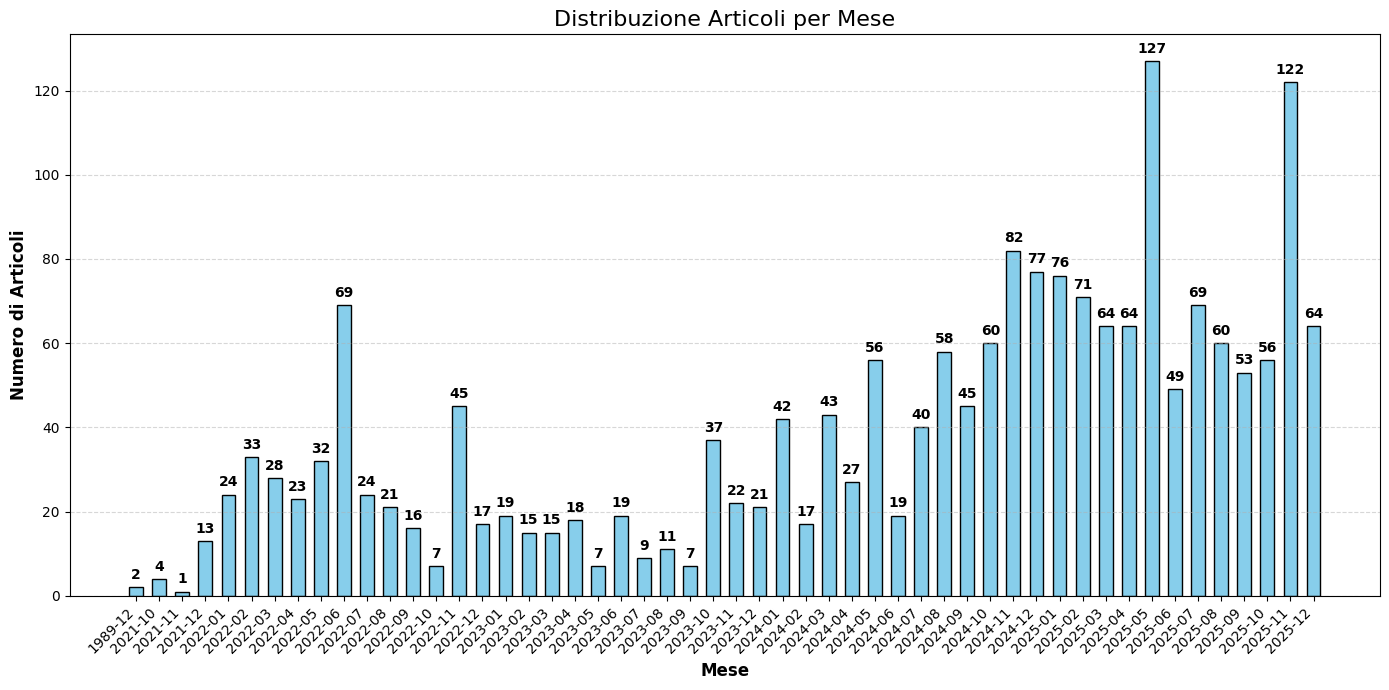

In [22]:
# 1. Connessione
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_project']
collection = db['Article']

# 2. Recupero Dati (SEMPLIFICATO)
# Non serve più l'aggregazione complessa. 
# Chiediamo a Mongo solo il campo 'pub_date' di tutti i documenti.
projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato! Assicurati di aver popolato il DB con il nuovo script.")
else:
    # 3. Preparazione DataFrame
    df = pd.DataFrame(data)
    
    # Verifica che la colonna 'pub_date' esista (per sicurezza)
    if 'pub_date' not in df.columns:
        print("ERRORE: Il campo 'pub_date' non è stato trovato nei documenti.")
        print("Esempio di documento nel DB:", collection.find_one())
    else:
        # Conversione data
        df['data'] = pd.to_datetime(df['pub_date'], errors='coerce')
        
        # Rimuove eventuali date non valide (NaT)
        df = df.dropna(subset=['data'])

        # Raggruppa per mese
        df['mese_anno'] = df['data'].dt.to_period('M')
        conteggio_mensile = df['mese_anno'].value_counts().sort_index()

        # Preparazione dati per il grafico
        mesi = conteggio_mensile.index.strftime('%Y-%m') 
        conteggi = conteggio_mensile.values

        # 4. Generazione Grafico (Il tuo codice di plotting era già ottimo!)
        plt.figure(figsize=(14, 7)) 
        
        plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

        plt.xlabel('Mese', fontsize=12, fontweight='bold')
        plt.ylabel('Numero di Articoli', fontsize=12, fontweight='bold')
        plt.title('Distribuzione Articoli per Mese', fontsize=16)
        
        # Formattazione asse X
        plt.xticks(
            rotation=45, 
            ha='right', 
            fontsize=10 
        )
        
        plt.grid(axis='y', linestyle='--', alpha=0.5)

        # Etichette sopra le barre
        for i, v in enumerate(conteggi):
            plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

        plt.subplots_adjust(bottom=0.2)
        plt.tight_layout()
        plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_28840\2312524740.py:27: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mese_anno'] = df['data'].dt.to_period('M')


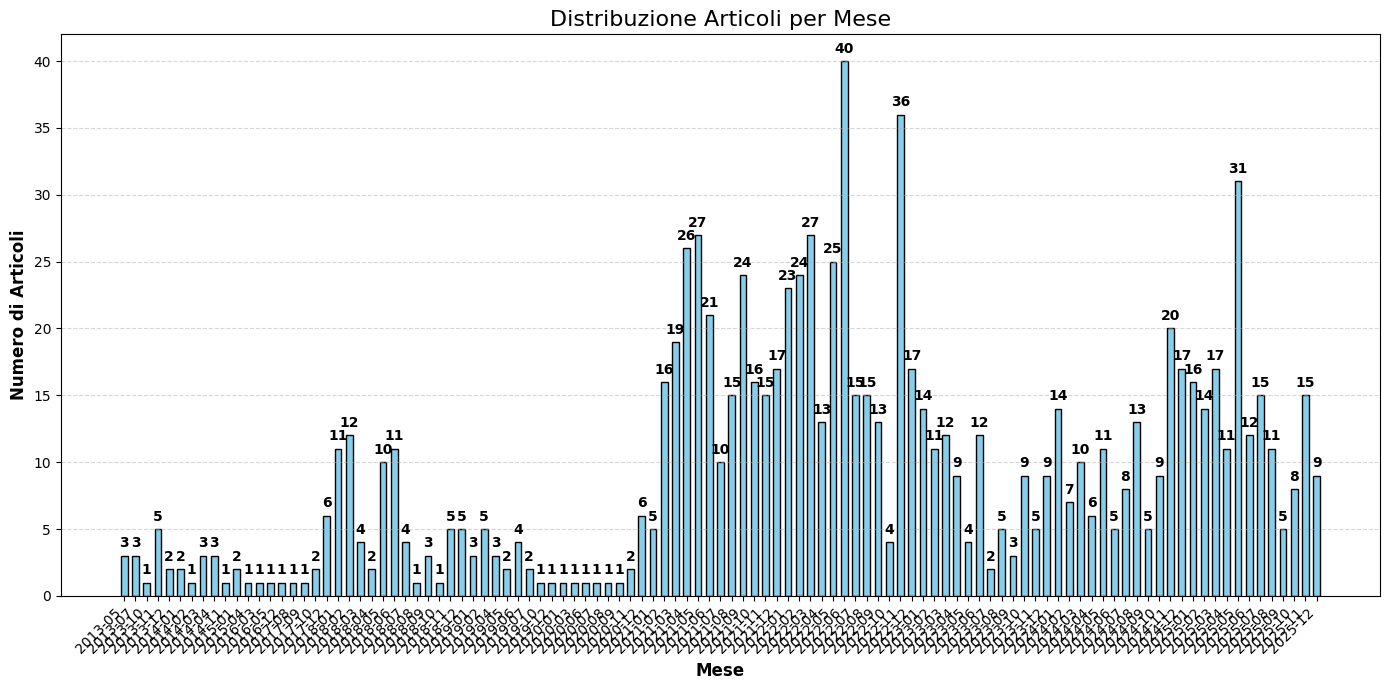

In [26]:


# 1. Connessione e Recupero Dati (come prima)
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_pr2']
collection = db['Article']

pipeline = [
    {"$unwind": "$response.docs"},
    {
        "$group": {
            "_id": "$response.docs._id",
            "data_pubblicazione": {"$first": "$response.docs.pub_date"}
        }
    },
    {"$project": {"_id": 0, "data_pubblicazione": 1}}
]

data = list(collection.aggregate(pipeline))

if not data:
    print("Nessun dato trovato!")
else:
    # 2. Preparazione Dati
    df = pd.DataFrame(data)
    df['data'] = pd.to_datetime(df['data_pubblicazione'], errors='coerce')
    
    # Raggruppa per mese
    df['mese_anno'] = df['data'].dt.to_period('M')
    conteggio_mensile = df['mese_anno'].value_counts().sort_index()

    # Formattiamo le etichette per renderle leggibili (es: "2025-11")
    # Convertiamo l'indice (PeriodIndex) in stringhe pulite
    mesi = conteggio_mensile.index.strftime('%Y-%m') 
    conteggi = conteggio_mensile.values

    # 3. Generazione Grafico MIGLIORATA
    # Aumentiamo la larghezza (14) per dare spazio alle date
    plt.figure(figsize=(14, 7)) 
    
    plt.bar(mesi, conteggi, color='skyblue', edgecolor='black', width=0.6)

    plt.xlabel('Mese', fontsize=12, fontweight='bold')
    plt.ylabel('Numero di Articoli', fontsize=12, fontweight='bold')
    plt.title('Distribuzione Articoli per Mese', fontsize=16)
    
    # --- MIGLIORAMENTO LEGGIBILITÀ ASSE X ---
    plt.xticks(
        rotation=45,      # Ruota di 45 gradi
        ha='right',       # Allinea l'ancoraggio del testo a destra (fondamentale!)
        fontsize=10       # Dimensione del font leggibile
    )
    
    # Griglia orizzontale per facilitare la lettura dei valori
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Aggiunge i numeri sopra le barre
    for i, v in enumerate(conteggi):
        plt.text(i, v + (max(conteggi)*0.01), str(v), ha='center', va='bottom', fontweight='bold')

    # Aumenta lo spazio sul fondo per evitare che le date vengano tagliate
    plt.subplots_adjust(bottom=0.2)
    
    plt.tight_layout()
    plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_28840\1056341244.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


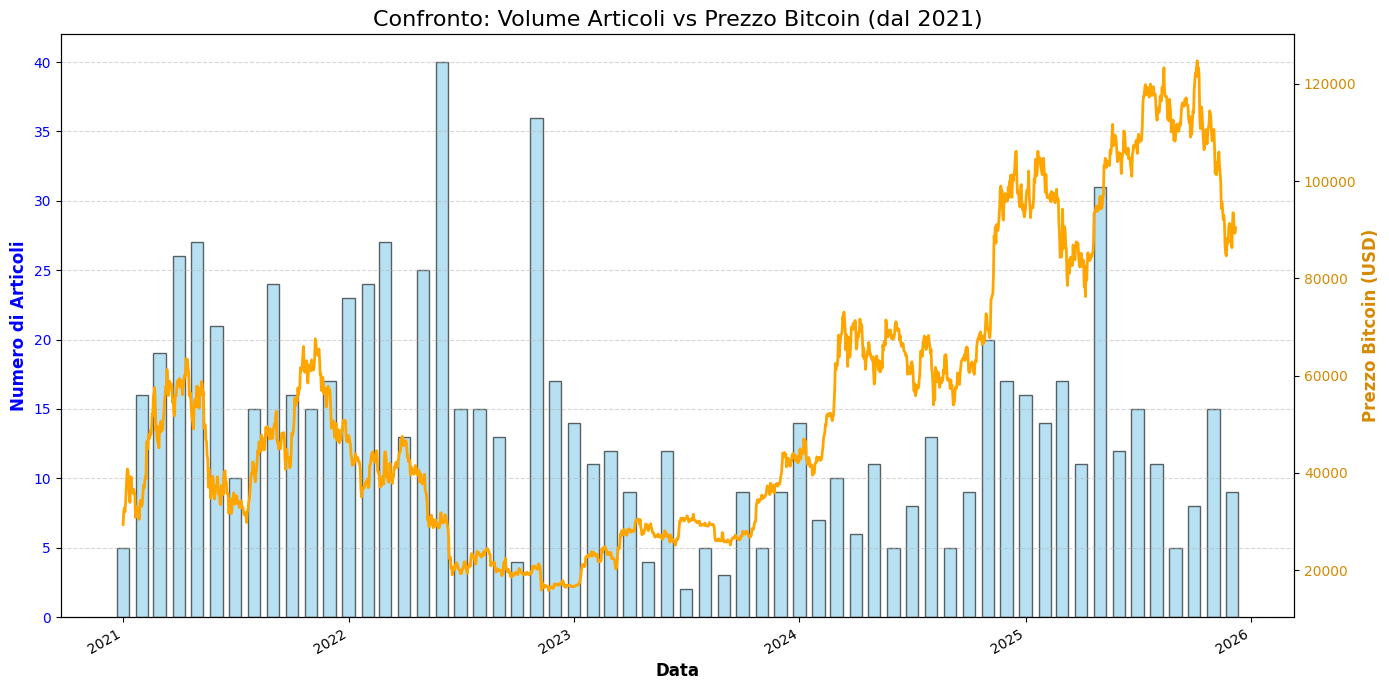

In [35]:
# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assumo che 'df_btc' sia il tuo DataFrame finanziario caricato in precedenza.
# Esempio: df_btc = yf.download(...)
# Filtriamo anche il Bitcoin per partire dal 2021 per allinearlo agli articoli
if 'df' in locals():
    df_btc_filtered = df[df.index >= '2021-01-01']
else:
    print("ERRORE: Assicurati di aver caricato il DataFrame 'df_btc' prima di eseguire questo codice.")
    # Crea un placeholder vuoto per evitare crash se copi-incolli tutto
    df_btc_filtered = pd.DataFrame() 

# --- 2. RECUPERO DATI ARTICOLI (MongoDB) ---
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_pr2']
collection = db['Article']

pipeline = [
    {"$unwind": "$response.docs"},
    {
        "$group": {
            "_id": "$response.docs._id",
            "data_pubblicazione": {"$first": "$response.docs.pub_date"}
        }
    },
    {"$project": {"_id": 0, "data_pubblicazione": 1}}
]

data = list(collection.aggregate(pipeline))

if not data:
    print("Nessun dato trovato!")
else:
    # Creazione DataFrame Articoli
    df_articles = pd.DataFrame(data)
    df_articles['data'] = pd.to_datetime(df_articles['data_pubblicazione'], errors='coerce')
    
    # --- FILTRO SOLO DOPO IL 2021 ---
    df_articles = df_articles[df_articles['data'] >= '2021-01-01']

    # Raggruppamento mensile
    # Usiamo dt.to_period('M') per raggruppare, ma poi convertiamo in Timestamp per il grafico
    conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()
    
    # Date per l'asse X (convertiamo i periodi in Timestamp per compatibilità con il grafico a linee)
    date_articoli = conteggio_mensile.index.to_timestamp()
    conteggi = conteggio_mensile.values

    # --- 3. GENERAZIONE GRAFICO COMBINATO ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # --- ASSE Y SINISTRO (BARRE - ARTICOLI) ---
    color_bar = 'skyblue'
    # width=20 perché l'asse X è temporale (giorni), quindi 20 giorni di larghezza per le barre
    ax1.bar(date_articoli, conteggi, color=color_bar, edgecolor='black', width=20, alpha=0.6, label='N. Articoli')
    
    ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Numero di Articoli', fontsize=12, fontweight='bold', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # --- ASSE Y DESTRO (LINEA - PREZZO BITCOIN) ---
    if not df_btc_filtered.empty:
        ax2 = ax1.twinx()  # Crea un secondo asse che condivide la stessa X
        color_line = 'orange'
        
        # Accediamo a Close -> BTC-USD
        prezzo_btc = df_btc_filtered['Close']['BTC-USD']
        
        ax2.plot(df_btc_filtered.index, prezzo_btc, color=color_line, linewidth=2, label='Prezzo BTC (Close)')
        ax2.set_ylabel('Prezzo Bitcoin (USD)', fontsize=12, fontweight='bold', color='#d68a00')
        ax2.tick_params(axis='y', labelcolor='#d68a00')
    
    # --- FORMATTAZIONE GENERALE ---
    plt.title('Confronto: Volume Articoli vs Prezzo Bitcoin (dal 2021)', fontsize=16)
    
    # Miglioriamo la formattazione delle date sull'asse X
    fig.autofmt_xdate()  # Ruota e allinea automaticamente le date
    
    plt.tight_layout()
    plt.show()

client.close()

C:\Users\tomma\AppData\Local\Temp\ipykernel_28840\1577494681.py:42: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()


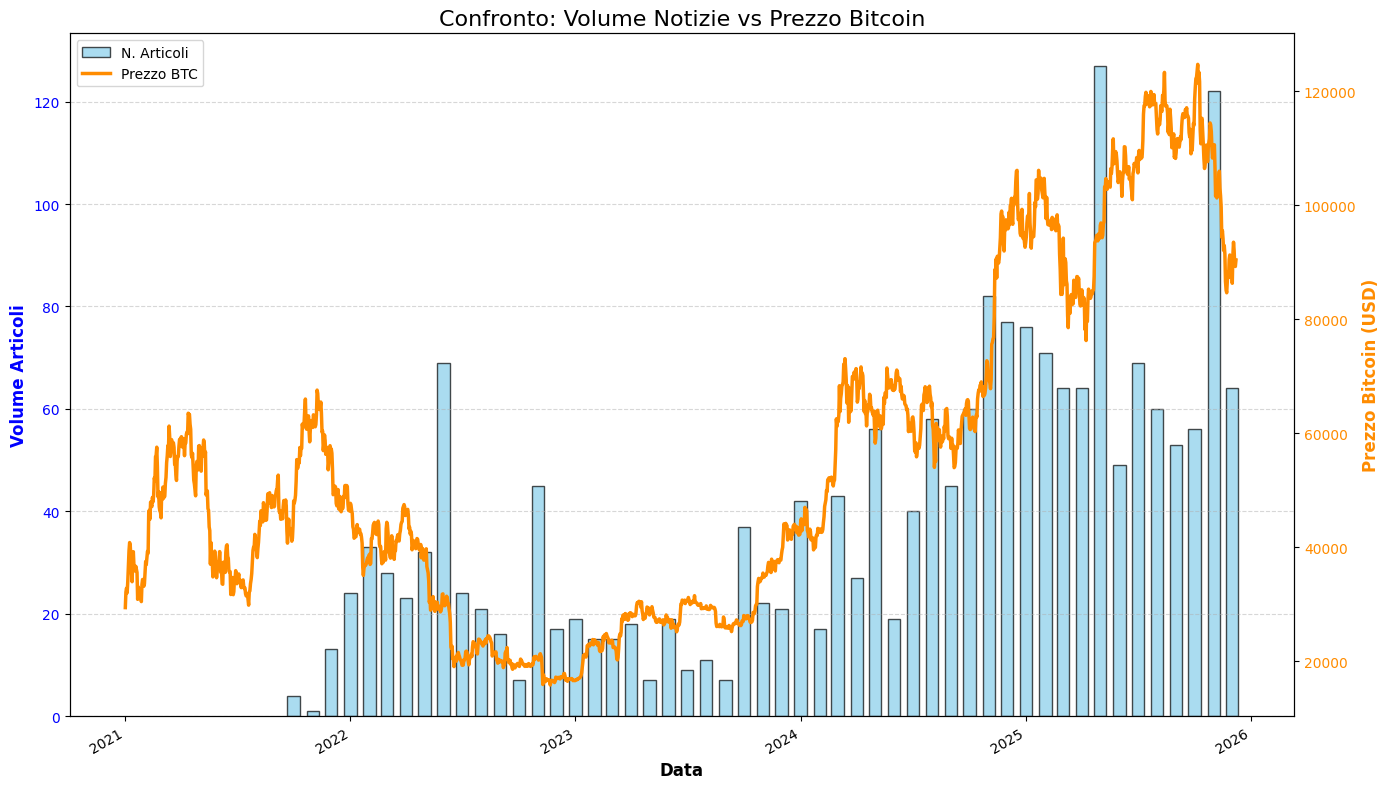

In [37]:

# --- 1. PREPARAZIONE DATI BITCOIN (df_btc) ---
# Assicura che 'df_btc' sia caricato. Se non c'è, crea un placeholder.
if 'df' not in locals():
    print("ATTENZIONE: 'df_btc' non trovato. Caricalo prima (es. con yfinance).")
    df_btc = pd.DataFrame()
else:
    df_btc = df.copy() # Lavoriamo su una copia

# Assicuriamo che l'indice sia datetime
if not df_btc.empty:
    if not pd.api.types.is_datetime64_any_dtype(df_btc.index):
        df_btc.index = pd.to_datetime(df_btc.index)
    # Filtriamo dal 2021 in poi per coerenza
    df_btc_filtered = df_btc[df_btc.index >= '2021-01-01']
else:
    df_btc_filtered = pd.DataFrame()


# --- 2. RECUPERO DATI ARTICOLI (IL TUO CODICE FUNZIONANTE) ---
client = MongoClient("mongodb://localhost:27017")
db = client['bitcoin_project']
collection = db['Article']

projection = {"pub_date": 1, "_id": 0}
data = list(collection.find({}, projection))

if not data:
    print("Nessun dato trovato su MongoDB!")
else:
    # Creazione DataFrame
    df_articles = pd.DataFrame(data)
    
    if 'pub_date' in df_articles.columns:
        # Conversione e Pulizia
        df_articles['data'] = pd.to_datetime(df_articles['pub_date'], errors='coerce')
        df_articles = df_articles.dropna(subset=['data'])
        
        # Filtro temporale (opzionale, per allineare al grafico BTC)
        df_articles = df_articles[df_articles['data'] >= '2021-01-01']

        # Raggruppamento per mese
        conteggio_mensile = df_articles['data'].dt.to_period('M').value_counts().sort_index()

        # *** TRUCCO IMPORTANTE ***
        # Convertiamo l'indice (Period) in Timestamp (inizio mese)
        # Questo permette a Matplotlib di sovrapporre correttamente la linea del Bitcoin
        date_articoli = conteggio_mensile.index.to_timestamp()
        conteggi = conteggio_mensile.values

        # --- 3. GENERAZIONE GRAFICO COMBINATO ---
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # ASSE Y SINISTRO (BARRE - ARTICOLI)
        ax1.bar(date_articoli, conteggi, color='skyblue', edgecolor='black', width=20, alpha=0.7, label='N. Articoli')
        
        ax1.set_xlabel('Data', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Volume Articoli', fontsize=12, fontweight='bold', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

        # ASSE Y DESTRO (LINEA - PREZZO BITCOIN)
        if not df_btc_filtered.empty:
            ax2 = ax1.twinx()
            color_line = '#FF8C00' # Arancione Bitcoin
            
            # Gestione sicura della colonna Close
            try:
                # Prova accesso standard o MultiIndex
                prezzo = df_btc_filtered['Close']['BTC-USD'] if 'BTC-USD' in df_btc_filtered['Close'] else df_btc_filtered['Close']
            except:
                prezzo = df_btc_filtered.iloc[:, 0] # Fallback brutale alla prima colonna
            
            ax2.plot(df_btc_filtered.index, prezzo, color=color_line, linewidth=2.5, label='Prezzo BTC')
            ax2.set_ylabel('Prezzo Bitcoin (USD)', fontsize=12, fontweight='bold', color=color_line)
            ax2.tick_params(axis='y', labelcolor=color_line)

            # Legenda Unificata
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
        else:
            ax1.legend(loc='upper left')

        plt.title('Confronto: Volume Notizie vs Prezzo Bitcoin', fontsize=16)
        fig.autofmt_xdate() # Formatta date asse X
        plt.tight_layout()
        plt.show()

    else:
        print("Errore: colonna 'pub_date' non trovata nel DataFrame.")

client.close()

### Other news API:

In [14]:
key = os.getenv("NEWS_KEY")
url = ('https://newsapi.org/v2/everything?'
       'q=Bitcoin&'
       'from=2025-11-10&'
       'sortBy=popularity&'
       f'apiKey={key}')

In [15]:
news_resp = requests.get(url).json()
news_resp

{'status': 'ok',
 'totalResults': 14234,
 'articles': [{'source': {'id': 'wired', 'name': 'Wired'},
   'author': 'Joel Khalili',
   'title': 'Inside a Wild Bitcoin Heist: Five-Star Hotels, Cash-Stuffed Envelopes, and Vanishing Funds',
   'description': 'Sophisticated crypto scams are on the rise. But few of them go to the lengths one bitcoin mining executive experienced earlier this year.',
   'url': 'https://www.wired.com/story/bitcoin-scam-mining-as-service/',
   'urlToImage': 'https://media.wired.com/photos/6913b909f757bec53ccf7811/191:100/w_1280,c_limit/Bitcoin-Heist-Business-1304706668.jpg',
   'publishedAt': '2025-11-17T10:00:00Z',
   'content': 'As Kent Halliburton stood in a bathroom at the Rosewood Hotel in central Amsterdam, thousands of miles from home, running his fingers through an envelope filled with 10,000 in crisp banknotes, he sta… [+2362 chars]'},
  {'source': {'id': 'the-verge', 'name': 'The Verge'},
   'author': 'Nilay Patel',
   'title': 'Square’s product chief on

In [16]:
len(news_resp['articles'])

100

## CryptoPanic:

In [31]:
# --- CONFIGURAZIONE ---
API_KEY = os.getenv("PANIC_KEY")
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "bitcoin_pr2"
COLL_NAME = "CryptoPanic_News" # Usiamo una collezione separata per ordine

# --- CONNESSIONE MONGO ---
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLL_NAME]

# --- CONFIGURAZIONE API ---
base_url = "https://cryptopanic.com/api/v1/posts/"
params = {
    "auth_token": API_KEY,
    "currencies": "BTC",    # Filtra solo Bitcoin
    "kind": "news",        # Solo notizie (esclude media/video)
    "public": "true"
}

print("Inizio scaricamento notizie da CryptoPanic...")

# Ciclo per scaricare più pagine
pagina_corrente = 1
max_pagine = 10  # Cambia questo numero se vuoi più dati

while base_url and pagina_corrente <= max_pagine:
    try:
        print(f"Scaricamento pagina {pagina_corrente}...")
        response = requests.get(base_url, params=params)
        data = response.json()
        
        # Controlla se ci sono risultati
        if "results" in data:
            posts = data["results"]
            
            # Inserimento in MongoDB
            if posts:
                # Aggiungiamo un campo per riconoscere la fonte facilmente
                for post in posts:
                    post['source_type'] = 'cryptopanic_api'
                
                collection.insert_many(posts)
                print(f"✅ Inseriti {len(posts)} articoli nel DB.")
            else:
                print("Nessun articolo trovato in questa pagina.")
        
        # Gestione Paginazione
        # L'API ci dà il link per la pagina successiva nel campo 'next'
        base_url = data.get("next")
        params = {} # I parametri sono già inclusi nell'url 'next', svuotiamo params
        
        pagina_corrente += 1
        time.sleep(1) # Pausa di cortesia per non essere bloccati
        
    except Exception as e:
        print(f"Errore: {e}")
        break

print("Finito!")
client.close()

Inizio scaricamento notizie da CryptoPanic...
Scaricamento pagina 1...
✅ Inseriti 20 articoli nel DB.
Finito!
